In [1]:
stock_name = "^GSPC"
date_predict_start = '2020-01-01'
data_range = 250
slide_range = 10
n_slide = 10
pv_range = 7
n_harm_lower_limit = 1
n_harm_upper_limit = 50
fit_method = 'rmse'
pv_method = 'CL'

x_length = 10
y_length = x_length
slide = y_length

profit_percentage = 0.1
loss_percentage = 0.1

# Import packages


In [2]:
import numpy as np
import pylab as pl
from numpy import fft
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
from dateutil.relativedelta import relativedelta
import math
import matplotlib.dates as mdates
import warnings
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import matplotlib.patches as patches

# Load data


In [3]:
def load_data(stock_name, date_predict_start, data_range, slide_range, n_slide):
    train_data = {}
    test_data = {}
    date_predict_start = datetime.datetime.strptime(
        date_predict_start, '%Y-%m-%d').date()
    date_data_start_list = []
    date_predict_start_list = []
    date_predict_end_list = []
    test_data_start_list = []
    all_data = yf.Ticker(stock_name).history(period='max')
    all_data.index = all_data.index.date
    check = date_predict_start in all_data.index
    while (check == False):
        date_predict_start = date_predict_start + \
            relativedelta(days=+1)
        check = date_predict_start in list(all_data.index)
    predict_start = all_data.index.get_loc(date_predict_start)
    for i in range(n_slide):
        predict_end = predict_start + data_range
        date_predict_end = all_data.iloc[predict_end].name
        data_start = predict_start - data_range
        date_data_start = all_data.iloc[data_start].name
        train_data['window_' + str(i)] = all_data.iloc[data_start:predict_start]
        test_data['window_' + str(i)] = all_data.iloc[predict_start:predict_end]
        date_data_start_list.append(date_data_start)
        date_predict_start_list.append(date_predict_start)
        date_predict_end_list.append(date_predict_end)
        test_data_start_list.append(test_data['window_' + str(i)].index[0])
        data_start = data_start + slide_range
        predict_start = predict_start + slide_range
        train_data['window_' + str(i)] = train_data['window_' +
                                                  str(i)].reset_index(drop=False)
        test_data['window_' + str(i)] = test_data['window_' +
                                                str(i)].reset_index(drop=False)

    return train_data, test_data, all_data, test_data_start_list


# Data preprocessing


In [4]:
def find_data_pv_CL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    for i in data:
        price = data[i]['Close']
        data[i]['peaks'] = pd.Series(dtype='float64')
        data[i]['valleys'] = pd.Series(dtype='float64')
        data[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(price)):
            if idx < pv_range:
                if price[idx] == price.iloc[0:pv_range*2+1].max():
                    data[i]['peaks'].iloc[idx] = price[idx]
                    data[i]['pv'].iloc[idx] = 'peak'
                if price[idx] == price.iloc[0:pv_range*2+1].min():
                    data[i]['valleys'].iloc[idx] = price[idx]
                    data[i]['pv'].iloc[idx] = 'valley'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
                data[i]['peaks'].iloc[idx] = price[idx]
                data[i]['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
                data[i]['valleys'].iloc[idx] = price[idx]
                data[i]['pv'].iloc[idx] = 'valley'


In [5]:
def find_data_pv_HL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    for i in data:
        high = data[i]['High']
        low = data[i]['Low']
        data[i]['peaks'] = pd.Series(dtype='float64')
        data[i]['valleys'] = pd.Series(dtype='float64')
        data[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(high)):
            if idx < pv_range and idx>0:
                if high[idx] == high.iloc[0:pv_range*2+1].max():
                    data[i]['peaks'].iloc[idx] = high[idx]
                    data[i]['pv'].iloc[idx] = 'peak'
                if low[idx] == low.iloc[0:pv_range*2+1].min():
                    data[i]['valleys'].iloc[idx] = low[idx]
                    data[i]['pv'].iloc[idx] = 'valley'
            if high[idx] == high.iloc[idx-pv_range:idx+pv_range].max():
                data[i]['peaks'].iloc[idx] = high[idx]
                data[i]['pv'].iloc[idx] = 'peak'
            if low[idx] == low.iloc[idx-pv_range:idx+pv_range].min():
                data[i]['valleys'].iloc[idx] = low[idx]
                data[i]['pv'].iloc[idx] = 'valley'


In [6]:
def preprocessing(train_data, test_data, pv_range, pv_method):
    if pv_method == 'CL':
        find_data_pv_CL_function(train_data, pv_range)
        find_data_pv_CL_function(test_data, pv_range)
    elif pv_method == 'HL':
        find_data_pv_HL_function(train_data, pv_range)
        find_data_pv_HL_function(test_data, pv_range)
    else :
        print('worng pv_method')


# Built Model


Get signal


In [7]:
def data_to_harmonics_function(data_stock, data_range):
    harmonics = {}
    for i in data_stock:
        harmonics[i] = {}
        # get data_stock's infomation
        data = data_stock[i]['Close']
        array_data = np.array(data)
        n_data = array_data.size
        time_data = np.arange(0, n_data)

        # detrend data
        # find linear trend in data
        Polynomial = np.polyfit(time_data, array_data, 1)
        data_notrend = array_data - Polynomial[0] * time_data    # detrended x

        # fft process
        data_freqdom = fft.fft(data_notrend, n=n_data)
        frequence = fft.fftfreq(n=n_data, d=1)
        f_positive = frequence[np.where(frequence > 0)]
        data_freqdom_positive = data_freqdom[np.where(frequence > 0)]

        # sort indexes
        indexes = list(range(f_positive.size))      # frequencies
        # sort method 1
        # indexes.sort(key = lambda i: np.absolute(frequence[i]))     # sort indexes by frequency, lower -> higher
        # sort method 2 :
        # sort indexes by amplitudes, lower -> higher
        indexes.sort(key=lambda i: np.absolute(data_freqdom[i]))
        indexes.reverse()       # sort indexes by amplitudes, higher -> lower

        # get data_all_time'size
        time_transfer = np.arange(0, data_range*2)

        # get harmonics
        for j in indexes:
            ampli = np.absolute(
                data_freqdom_positive[j]) / n_data     # amplitude
            phase = np.angle(data_freqdom_positive[j])      # phase
            harmonics[i][j] = ampli * \
                np.cos(2 * np.pi * f_positive[j] * time_transfer + phase)
    return harmonics


In [8]:
def mix_harmonics_function(harmonics, n_harm_lower_limit, n_harm_upper_limit):
    processed_signal = {}
    for i in harmonics:
        processed_signal[i] = {}
        for n_harm in range(n_harm_lower_limit, n_harm_upper_limit+1):
            mixed_harmonic = np.zeros(len(harmonics[i][0]))
            # for j in range(n_harm):
            for j in range(2, n_harm):
                mixed_harmonic += harmonics[i][j]
            processed_signal[i][n_harm] = pd.DataFrame(
                {'Close': mixed_harmonic})
    return processed_signal


Signal processing


In [9]:
def find_signal_pv_function(signal, pv_range):
    pd.options.mode.chained_assignment = None
    for i in signal:
        for j in signal[i]:
            data = signal[i][j]['Close']
            signal[i][j]['peaks'] = pd.Series(dtype='float64')
            signal[i][j]['valleys'] = pd.Series(dtype='float64')
            signal[i][j]['pv'] = pd.Series(dtype='str')
            for idx in range(0, len(data)):
                if idx < pv_range and idx>0:
                    if data[idx] == data.iloc[0:pv_range*2+1].max():
                        signal[i][j]['peaks'].iloc[idx] = data[idx]
                        signal[i][j]['pv'].iloc[idx] = 'peak'
                    if data[idx] == data.iloc[0:pv_range*2+1].min():
                        signal[i][j]['valleys'].iloc[idx] = data[idx]
                        signal[i][j]['pv'].iloc[idx] = 'valley'
                if data[idx] == data.iloc[idx-pv_range:idx+pv_range].max():
                    signal[i][j]['peaks'].iloc[idx] = data[idx]
                    signal[i][j]['pv'].iloc[idx] = 'peak'
                if data[idx] == data.iloc[idx-pv_range:idx+pv_range].min():
                    signal[i][j]['valleys'].iloc[idx] = data[idx]
                    signal[i][j]['pv'].iloc[idx] = 'valley'


In [10]:
def find_signal_lead_train_function(data, processed_signal):
    for d in data:
        for p in processed_signal[d]:
            # processed_signal[d][p]['pv'] = pd.Series(dtype='str')
            processing_signal = processed_signal[d][p].head(len(data[d]))
            p_data = pd.DataFrame(
                {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
            p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
            p_data_count = list(p_data['count'])
            p_signal = pd.DataFrame(
                {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
            p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
            p_signal_list = list(p_signal['count'])
            p_lead = []
            for i in range(0, len(p_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(p_data_count)):
                    temp.append((p_data_count[j] - p_signal_list[i]))
                    temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                p_lead.append(temp_2)
            p_signal['lead'] = p_lead

            v_data = pd.DataFrame(
                {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
            v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
            v_data_count = list(v_data['count'])
            v_signal = pd.DataFrame(
                {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
            v_signal = v_signal.drop(
                v_signal[v_signal['valleys'].isna()].index)
            v_signal_list = list(v_signal['count'])
            v_lead = []
            for i in range(0, len(v_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(v_data_count)):
                    temp.append((v_data_count[j] - v_signal_list[i]))
                    temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                v_lead.append(temp_2)
            v_signal['lead'] = v_lead

            processed_signal[d][p]['lead'] = pd.Series(dtype='float64')
            processed_signal[d][p]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
            processed_signal[d][p]['lead'].loc[v_signal['lead'].index] = v_signal['lead']


In [11]:
def build_model(train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range):
    harmonics = data_to_harmonics_function(train_data, data_range)
    processed_signal = mix_harmonics_function(
        harmonics, n_harm_lower_limit, n_harm_upper_limit)
    find_signal_pv_function(processed_signal, pv_range)
    find_signal_lead_train_function(train_data, processed_signal)
    return harmonics, processed_signal


# Select model


In [12]:
def get_fit_error_function(processed_signal, fit_method):
    errors = {}
    error = []
    for i in processed_signal:
        errors[i] = {}
        for j in processed_signal[i]:
            signal_dropna = processed_signal[i][j].drop(
                processed_signal[i][j][processed_signal[i][j]['lead'].isna()].index)
            if fit_method == 'mean':
                error = signal_dropna['lead'].mean()
            elif fit_method == 'abs':
                error = abs(signal_dropna['lead']).mean()
            elif fit_method == 'rmse':
                mse = np.square(np.subtract(np.zeros_like(
                    signal_dropna['lead']), signal_dropna['lead'])).mean()
                rmse = math.sqrt(mse)
                error = rmse
            else :
                print('worng fit_method')
            errors[i][j] = error
    return errors


In [13]:
def get_best_fit_harm_function(processed_signal, errors):
    best_error = {}
    best_fit_harm = {}
    for i in processed_signal:
        best_error[i] = pd.Series(errors[i]).abs().min()
        best_fit_harm[i] = pd.Series(errors[i]).abs().idxmin()
    return best_fit_harm, best_error


In [14]:
def find_signal_lead_test_function(data, processed_signal):
    for d in data:
        for p in processed_signal[d]:
            processed_signal[d][p]['pv'] = pd.Series(dtype='str')
            processing_signal = processed_signal[d][p].tail(len(data[d]))
            p_data = pd.DataFrame(
                {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
            p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
            p_data_count = list(p_data['count'])
            p_signal = pd.DataFrame(
                {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
            p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
            p_signal_list = list(p_signal['count'])
            p_lead = []
            for i in range(0, len(p_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(p_data_count)):
                    temp.append((p_data_count[j] - p_signal_list[i]))
                    temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                p_lead.append(temp_2)
            p_signal['lead'] = p_lead

            v_data = pd.DataFrame(
                {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
            v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
            v_data_count = list(v_data['count'])
            v_signal = pd.DataFrame(
                {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
            v_signal = v_signal.drop(
                v_signal[v_signal['valleys'].isna()].index)
            v_signal_list = list(v_signal['count'])
            v_lead = []
            for i in range(0, len(v_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(v_data_count)):
                    temp.append((v_data_count[j] - v_signal_list[i]))
                    temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                v_lead.append(temp_2)
            v_signal['lead'] = v_lead

            processed_signal[d][p]['lead'] = pd.Series(dtype='float64')
            processed_signal[d][p]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
            processed_signal[d][p]['pv'].loc[p_signal['lead'].index] = 'peak'
            processed_signal[d][p]['lead'].loc[v_signal['lead'].index] = v_signal['lead']
            processed_signal[d][p]['pv'].loc[v_signal['lead'].index] = 'valley'


In [15]:
def get_first_lead_function(processed_signal, best_fit_harm):
    first_date = {}
    lead = {}
    pv = {}
    for i in processed_signal:
        harm = best_fit_harm[i]
        temp = processed_signal[i][harm].loc[list(
            processed_signal[i][harm]['lead'].dropna().index)[0]]
        first_index = list(processed_signal[i][harm]
                             ['lead'].dropna().index)[0]
        first_date[i] = processed_signal[i][harm].index.get_loc(first_index)
        lead[i] = temp['lead']
        pv[i] = temp['pv']
    return first_date, lead, pv


In [16]:
def select_model(test_data, processed_signal, fit_method):
    errors = get_fit_error_function(processed_signal, fit_method)
    best_fit_harm, best_error = get_best_fit_harm_function(
        processed_signal, errors)
    find_signal_lead_test_function(test_data, processed_signal)
    first_date, lead, pv = get_first_lead_function(
        processed_signal, best_fit_harm)
    return errors, best_fit_harm, best_error, first_date, lead, pv


# Evaluate model


In [17]:
def built_result_table_function(processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm):
    result_table = pd.DataFrame(columns=[
        's_date', 't_date', 'lead', 'ans_date', 'pv', 'error', 'best_fit'])
    for i in processed_signal:
        result_table.loc[i, 'error'] = round(best_error[i], 2)
        result_table.loc[i, 'best_fit'] = best_fit_harm[i]
        result_table.loc[i, 'lead'] = lead[i]
        result_table.loc[i, 'pv'] = pv[i]
    result_table['s_date'] = test_data_start_list
    return result_table


In [18]:
def result_table_process_function(result_table, all_data, first_date, data_range):
    for i in result_table.index:
        t_date = all_data.iloc[all_data.index.get_loc(result_table.loc[i, 's_date']) + first_date[i] - data_range].name
        result_table.loc[i, 't_date'] = t_date
        ans = all_data.iloc[int(all_data.index.get_loc(t_date) + result_table.loc[i, 'lead'])].name
        result_table.loc[i, 'ans_date'] = ans

In [19]:
def compute_final_error_function(result_table):
    final_error = round(
        sum([abs(ele) for ele in result_table['lead']]) / len(result_table['lead']), 2)
    return final_error


In [20]:
def evaluate_model(processed_signal, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range):
    result_table = built_result_table_function(
        processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)
    result_table_process_function(
        result_table, all_data, first_date, data_range)
    final_error = compute_final_error_function(result_table)
    return result_table, final_error


# Draw plot


In [21]:
def find_data_pv_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    price = data['Close']
    data['peaks'] = pd.Series(dtype='float64')
    data['valleys'] = pd.Series(dtype='float64')
    data['pv'] = pd.Series(dtype='str')
    for idx in range(0, len(price)):
        if idx < pv_range and idx>0:
            if price[idx] == price.iloc[0:pv_range*2+1].max():
                data['peaks'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[0:pv_range*2+1].min():
                data['valleys'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'valleys'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
            data['peaks'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'peak'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
            data['valleys'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'valleys'


In [22]:
def draw_plot_result_table(test_data, all_data, result_table, pv_range):
    date_list = sorted(
        list(result_table['s_date']) + list(result_table['t_date']) + list(result_table['ans_date']))
    all_index = all_data.loc[date_list[0]:date_list[-1]].index
    fig, axes = plt.subplots(2, 1, figsize=(30, 8), sharex=True)
    test_data_copy = test_data.copy()
    for d in test_data :
        test_data_copy[d].index = test_data[d]['index']
        test_data_copy[d] = test_data_copy[d].drop(test_data_copy[d][test_data_copy[d].index > date_list[-1]].index)
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['Close'], 'gray', label='data', linewidth=3)
    for d in test_data_copy :
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['peaks'],
                    '^', c='royalblue', label='peaks')
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['valleys'], 'v',
                    c='orangered', label='valleys')
    plot_model = pd.DataFrame(index=all_index, columns=[
                                's_date', 't_date', 'ans_date', 'lead', 'pv'])
    plot_model['s_date'].loc[result_table['s_date']] = True
    plot_model['t_date'].loc[result_table['t_date']] = True
    plot_model['lead'].loc[result_table['t_date']] = list(result_table['lead'])
    plot_model['pv'].loc[result_table['t_date']] = list(result_table['pv'])
    plot_model['ans_date'].loc[result_table['ans_date']] = True
    for i, label in enumerate(plot_model['lead']):
        if plot_model['pv'][i] == 'peak':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], '^',
                            c='royalblue')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)
        elif plot_model['pv'][i] == 'valley':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], 'v',
                            c='orangered')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)

    axes[0].set_ylabel("Stock price", fontsize=14)
    axes[0].grid(True)
    axes[1].grid(True)
    axes[1].set_ylabel("lead", fontsize=14)
    plt.show()

# Main function


In [23]:
def main_funtion(
    stock_name, date_predict_start, data_range, slide_range,
        n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method):

    # 1. Load data
    train_data, test_data, all_data, test_data_start_list = load_data(
        stock_name, date_predict_start, data_range, slide_range, n_slide)
    # 2. Preprocessing
    preprocessing(train_data, test_data, pv_range, pv_method)
    # 3. Build model
    harmonics, model = build_model(
        train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range)
    # 4. Select model
    errors, best_fit_harm, best_error, first_date, lead, pv = select_model(test_data,
                                                                           model, fit_method)
    # 5. Evaluate model
    result_table, final_error = evaluate_model(
        model, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range)
    print('final_error = ', final_error)
    with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
        print(result_table)
    draw_plot_result_table(test_data, all_data, result_table, pv_range)
    # return harmonics, model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error


In [24]:
# main_funtion(
#     stock_name, date_predict_start, data_range, slide_range,
#         n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method)

# Lstm function

In [25]:
def preprocessing_train_data_Lstm(train_data, x_length, y_length, slide):
    x_train = {}
    y_train = {}
    for i in train_data:
        scaler = MinMaxScaler(feature_range=(-1,1))
        scaled_data = scaler.fit_transform(train_data[i]['Close'].values.reshape(-1,1))
        x_train[i] = []
        y_train[i] = []
        # for x in range(x_length+y_length, len(scaled_data), slide):
        for x in range(x_length+y_length, len(scaled_data)):
            x_train[i].append(scaled_data[x-x_length-y_length:x-y_length])
            y_train[i].append(scaled_data[x-y_length:x])
        x_train[i], y_train[i] = np.array(x_train[i]), np.array(y_train[i])
        # 將x_train數組的形狀轉換為（樣本數，天數，特徵數）的形式，這裡的特徵數為1
        x_train[i] = np.reshape(x_train[i], (x_train[i].shape[0], x_train[i].shape[1], 1))
        y_train[i] = np.reshape(y_train[i], (y_train[i].shape[0], y_train[i].shape[1], 1))
    return x_train, y_train

In [26]:
def LSTM_model(y_length, input_shape):
    model = Sequential()
    model.add(LSTM(units = 256, return_sequences = True, input_shape = input_shape))
    model.add(Dropout(0.4))
    model.add(LSTM(units = 128, return_sequences = True))
    model.add(Dropout(0.4))
    model.add(LSTM(units = 64))
    model.add(Dropout(0.4))
    model.add(Dense(units=y_length))
    return model

In [27]:
def build_Lstm_model(train_data, y_length, input_shape):
    model = {}
    for i in train_data:
        model[i] = LSTM_model(y_length, input_shape)
        model[i].compile(optimizer='adam', 
                    loss='mean_squared_error')
        # model[i].summary()
    return model

In [28]:
def train_Lstm_model(train_data, model, x_train, y_train):
    history = {}
    for i in tqdm(train_data):
        earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2)
        history[i] = model[i].fit(x_train[i], y_train[i], epochs=25, batch_size=32, 
                            callbacks = [earlystopper], validation_split = 0.2, shuffle=True)
    return history

In [29]:
def preprocessing_test_data_Lstm(train_data, test_data, x_length, y_length, slide):
    x_test = {}
    y_test = {}
    for i in test_data:
        scaler = MinMaxScaler(feature_range=(-1,1))
        model_inputs = pd.concat((train_data[i]['Close'].iloc[-x_length:], test_data[i]['Close'])).values
        model_inputs = model_inputs.reshape(-1,1)
        model_inputs = scaler.fit_transform(model_inputs)
        x_test[i] = []
        y_test[i] = []
        for x in range(x_length+y_length, len(model_inputs), slide):
            x_test[i].append(model_inputs[x-x_length-y_length:x-y_length])
            y_test[i].append(model_inputs[x-y_length:x])
        x_test[i], y_test[i] = np.array(x_test[i]), np.array(y_test[i])
        x_test[i] = np.reshape(x_test[i], (x_test[i].shape[0], x_test[i].shape[1], 1))
        y_test[i] = np.reshape(y_test[i], (y_test[i].shape[0], y_test[i].shape[1], 1))
    return x_test, y_test

In [30]:
def predicting_creat_processed_signal_Lstm(x_test, test_data, model):
    processed_signal = {}
    for i in test_data:
        predicted_prices = model[i].predict(x_test[i])
        processed_signal[i] = {}
        processed_signal[i][0] = pd.DataFrame(
            {'Close': predicted_prices.flatten()}, index=test_data[i].index[:len(predicted_prices.flatten())])
    return processed_signal

In [31]:
def result_table_process_Lstm_function(result_table, all_data, first_date, data_range):
    for i in result_table.index:
        t_date = all_data.iloc[int(all_data.index.get_loc(result_table.loc[i, 's_date'])) + first_date[i]].name
        result_table.loc[i, 't_date'] = t_date
        ans = all_data.iloc[int(all_data.index.get_loc(t_date) + result_table.loc[i, 'lead'])].name
        result_table.loc[i, 'ans_date'] = ans

In [32]:
# 1. Load data
train_data, test_data, all_data, test_data_start_list = load_data(
    stock_name, date_predict_start, data_range, slide_range, n_slide)
# 2. Preprocessing
preprocessing(train_data, test_data, pv_range, pv_method)
x_train, y_train = preprocessing_train_data_Lstm(train_data, x_length, y_length, slide)
x_test, y_test = preprocessing_test_data_Lstm(train_data, test_data, x_length, y_length, slide)

In [33]:
# 3. Build model
# harmonics, model = build_model(
    # train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range)
# harmonics = data_to_harmonics_function(train_data, data_range)
# processed_signal_FFT = mix_harmonics_function(
#     harmonics, n_harm_lower_limit, n_harm_upper_limit)
# processed_signal = processed_signal_FFT

input_shape = (x_train[list(x_train.keys())[0]].shape[1],1)
model = build_Lstm_model(train_data, y_length, input_shape)
history = train_Lstm_model(train_data, model, x_train, y_train)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/25
6/6 [==============================] - 23s 2s/step - loss: 0.0521 - val_loss: 0.2298
Epoch 2/25
6/6 [==============================] - 1s 192ms/step - loss: 0.0305 - val_loss: 0.1059
Epoch 3/25
6/6 [==============================] - 1s 223ms/step - loss: 0.0281 - val_loss: 0.1731
Epoch 4/25
6/6 [==============================] - 1s 149ms/step - loss: 0.0263 - val_loss: 0.1689
Epoch 5/25
6/6 [==============================] - 1s 197ms/step - loss: 0.0257 - val_loss: 0.1410
Epoch 6/25
6/6 [==============================] - 1s 146ms/step - loss: 0.0253 - val_loss: 0.1634
Epoch 7/25
6/6 [==============================] - 1s 139ms/step - loss: 0.0240 - val_loss: 0.1685
Epoch 7: early stopping


 10%|█         | 1/10 [00:28<04:18, 28.69s/it]

Epoch 1/25
6/6 [==============================] - 37s 881ms/step - loss: 0.0665 - val_loss: 0.2381
Epoch 2/25
6/6 [==============================] - 1s 139ms/step - loss: 0.0443 - val_loss: 0.2433
Epoch 3/25
6/6 [==============================] - 1s 171ms/step - loss: 0.0425 - val_loss: 0.1876
Epoch 4/25
6/6 [==============================] - 1s 214ms/step - loss: 0.0367 - val_loss: 0.1815
Epoch 5/25
6/6 [==============================] - 1s 183ms/step - loss: 0.0345 - val_loss: 0.1956
Epoch 6/25
6/6 [==============================] - 1s 216ms/step - loss: 0.0328 - val_loss: 0.1827
Epoch 7/25
6/6 [==============================] - 1s 173ms/step - loss: 0.0317 - val_loss: 0.1987
Epoch 8/25
6/6 [==============================] - 1s 176ms/step - loss: 0.0313 - val_loss: 0.1960
Epoch 9/25
6/6 [==============================] - 1s 185ms/step - loss: 0.0324 - val_loss: 0.2281
Epoch 9: early stopping


 20%|██        | 2/10 [01:13<05:06, 38.37s/it]

Epoch 1/25
6/6 [==============================] - 49s 818ms/step - loss: 0.1179 - val_loss: 0.2529
Epoch 2/25
6/6 [==============================] - 0s 73ms/step - loss: 0.0588 - val_loss: 0.2552
Epoch 3/25
6/6 [==============================] - 0s 77ms/step - loss: 0.0587 - val_loss: 0.2254
Epoch 4/25
6/6 [==============================] - 1s 89ms/step - loss: 0.0537 - val_loss: 0.1971
Epoch 5/25
6/6 [==============================] - 1s 136ms/step - loss: 0.0476 - val_loss: 0.1779
Epoch 6/25
6/6 [==============================] - 1s 116ms/step - loss: 0.0434 - val_loss: 0.1540
Epoch 7/25
6/6 [==============================] - 1s 141ms/step - loss: 0.0452 - val_loss: 0.1655
Epoch 8/25
6/6 [==============================] - 1s 155ms/step - loss: 0.0443 - val_loss: 0.1651
Epoch 9/25
6/6 [==============================] - 1s 193ms/step - loss: 0.0438 - val_loss: 0.1912
Epoch 10/25
6/6 [==============================] - 1s 171ms/step - loss: 0.0444 - val_loss: 0.1671
Epoch 11/25
6/6 [====

 30%|███       | 3/10 [02:11<05:30, 47.27s/it]

Epoch 1/25
6/6 [==============================] - 50s 3s/step - loss: 0.1580 - val_loss: 0.2268
Epoch 2/25
6/6 [==============================] - 1s 178ms/step - loss: 0.0700 - val_loss: 0.2226
Epoch 3/25
6/6 [==============================] - 1s 144ms/step - loss: 0.0650 - val_loss: 0.1900
Epoch 4/25
6/6 [==============================] - 1s 181ms/step - loss: 0.0593 - val_loss: 0.1643
Epoch 5/25
6/6 [==============================] - 2s 288ms/step - loss: 0.0557 - val_loss: 0.1472
Epoch 6/25
6/6 [==============================] - 1s 201ms/step - loss: 0.0490 - val_loss: 0.1119
Epoch 7/25
6/6 [==============================] - 1s 225ms/step - loss: 0.0489 - val_loss: 0.1024
Epoch 8/25
6/6 [==============================] - 1s 243ms/step - loss: 0.0488 - val_loss: 0.0951
Epoch 9/25
6/6 [==============================] - 2s 294ms/step - loss: 0.0436 - val_loss: 0.0887
Epoch 10/25
6/6 [==============================] - 1s 210ms/step - loss: 0.0433 - val_loss: 0.0924
Epoch 11/25
6/6 [====

 40%|████      | 4/10 [03:31<06:00, 60.13s/it]

Epoch 1/25
6/6 [==============================] - 63s 4s/step - loss: 0.1428 - val_loss: 0.2899
Epoch 2/25
6/6 [==============================] - 1s 177ms/step - loss: 0.0676 - val_loss: 0.2609
Epoch 3/25
6/6 [==============================] - 1s 195ms/step - loss: 0.0609 - val_loss: 0.2050
Epoch 4/25
6/6 [==============================] - 1s 212ms/step - loss: 0.0552 - val_loss: 0.1555
Epoch 5/25
6/6 [==============================] - 1s 172ms/step - loss: 0.0507 - val_loss: 0.1235
Epoch 6/25
6/6 [==============================] - 1s 264ms/step - loss: 0.0489 - val_loss: 0.0902
Epoch 7/25
6/6 [==============================] - 1s 230ms/step - loss: 0.0453 - val_loss: 0.0797
Epoch 8/25
6/6 [==============================] - 1s 157ms/step - loss: 0.0471 - val_loss: 0.0611
Epoch 9/25
6/6 [==============================] - 1s 255ms/step - loss: 0.0465 - val_loss: 0.0636
Epoch 10/25
6/6 [==============================] - 1s 197ms/step - loss: 0.0461 - val_loss: 0.0438
Epoch 11/25
6/6 [====

 50%|█████     | 5/10 [04:50<05:34, 66.87s/it]

Epoch 1/25
6/6 [==============================] - 54s 3s/step - loss: 0.0532 - val_loss: 0.2091
Epoch 2/25
6/6 [==============================] - 2s 321ms/step - loss: 0.0308 - val_loss: 0.1339
Epoch 3/25
6/6 [==============================] - 1s 265ms/step - loss: 0.0277 - val_loss: 0.1238
Epoch 4/25
6/6 [==============================] - 1s 174ms/step - loss: 0.0247 - val_loss: 0.1427
Epoch 5/25
6/6 [==============================] - 1s 187ms/step - loss: 0.0225 - val_loss: 0.1496
Epoch 6/25
6/6 [==============================] - 1s 162ms/step - loss: 0.0228 - val_loss: 0.2403
Epoch 7/25
6/6 [==============================] - 1s 187ms/step - loss: 0.0210 - val_loss: 0.2656
Epoch 8/25
6/6 [==============================] - 1s 179ms/step - loss: 0.0197 - val_loss: 0.4913
Epoch 8: early stopping


 60%|██████    | 6/10 [05:53<04:22, 65.52s/it]

Epoch 1/25
6/6 [==============================] - 49s 2s/step - loss: 0.1028 - val_loss: 0.2744
Epoch 2/25
6/6 [==============================] - 1s 116ms/step - loss: 0.0398 - val_loss: 0.2506
Epoch 3/25
6/6 [==============================] - 1s 114ms/step - loss: 0.0356 - val_loss: 0.2405
Epoch 4/25
6/6 [==============================] - 1s 110ms/step - loss: 0.0275 - val_loss: 0.2448
Epoch 5/25
6/6 [==============================] - 1s 107ms/step - loss: 0.0233 - val_loss: 0.2476
Epoch 6/25
6/6 [==============================] - 1s 116ms/step - loss: 0.0217 - val_loss: 0.2722
Epoch 7/25
6/6 [==============================] - 1s 105ms/step - loss: 0.0211 - val_loss: 0.2715
Epoch 8/25
6/6 [==============================] - 1s 121ms/step - loss: 0.0205 - val_loss: 0.2895
Epoch 8: early stopping


 70%|███████   | 7/10 [06:47<03:05, 61.81s/it]

Epoch 1/25
6/6 [==============================] - 50s 2s/step - loss: 0.1322 - val_loss: 0.3279
Epoch 2/25
6/6 [==============================] - 1s 120ms/step - loss: 0.0532 - val_loss: 0.2991
Epoch 3/25
6/6 [==============================] - 1s 138ms/step - loss: 0.0425 - val_loss: 0.3331
Epoch 4/25
6/6 [==============================] - 1s 166ms/step - loss: 0.0308 - val_loss: 0.3078
Epoch 5/25
6/6 [==============================] - 1s 133ms/step - loss: 0.0250 - val_loss: 0.3394
Epoch 6/25
6/6 [==============================] - 1s 111ms/step - loss: 0.0256 - val_loss: 0.3362
Epoch 7/25
6/6 [==============================] - 1s 101ms/step - loss: 0.0260 - val_loss: 0.3324
Epoch 7: early stopping


 80%|████████  | 8/10 [07:41<01:58, 59.48s/it]

Epoch 1/25
6/6 [==============================] - 46s 2s/step - loss: 0.1518 - val_loss: 0.3393
Epoch 2/25
6/6 [==============================] - 1s 87ms/step - loss: 0.0499 - val_loss: 0.2916
Epoch 3/25
6/6 [==============================] - 1s 93ms/step - loss: 0.0468 - val_loss: 0.3321
Epoch 4/25
6/6 [==============================] - 1s 88ms/step - loss: 0.0349 - val_loss: 0.3425
Epoch 5/25
6/6 [==============================] - 1s 100ms/step - loss: 0.0293 - val_loss: 0.3285
Epoch 6/25
6/6 [==============================] - 0s 85ms/step - loss: 0.0291 - val_loss: 0.3613
Epoch 7/25
6/6 [==============================] - 0s 83ms/step - loss: 0.0271 - val_loss: 0.3495
Epoch 7: early stopping


 90%|█████████ | 9/10 [08:31<00:56, 56.32s/it]

Epoch 1/25
6/6 [==============================] - 41s 2s/step - loss: 0.2046 - val_loss: 0.2408
Epoch 2/25
6/6 [==============================] - 1s 168ms/step - loss: 0.0656 - val_loss: 0.3028
Epoch 3/25
6/6 [==============================] - 1s 115ms/step - loss: 0.0508 - val_loss: 0.3131
Epoch 4/25
6/6 [==============================] - 1s 88ms/step - loss: 0.0442 - val_loss: 0.3526
Epoch 5/25
6/6 [==============================] - 1s 100ms/step - loss: 0.0386 - val_loss: 0.3017
Epoch 6/25
6/6 [==============================] - 0s 85ms/step - loss: 0.0332 - val_loss: 0.3372
Epoch 6: early stopping


100%|██████████| 10/10 [09:15<00:00, 55.56s/it]


In [34]:
processed_signal = predicting_creat_processed_signal_Lstm(x_test, test_data, model)
find_signal_pv_function(processed_signal, pv_range)
find_signal_lead_train_function(train_data, processed_signal)

1/1 [==============================] - 5s 5s/step


In [35]:
# 4. Select model
# errors, best_fit_harm, best_error, first_date, lead, pv = select_model(test_data,
#                                                                         model, fit_method)
errors = get_fit_error_function(processed_signal, fit_method)
best_fit_harm, best_error = get_best_fit_harm_function(
    processed_signal, errors)
find_signal_lead_test_function(test_data, processed_signal)
first_date, lead, pv = get_first_lead_function(
    processed_signal, best_fit_harm)


In [36]:
# 5. Evaluate model
# result_table, final_error = evaluate_model(
#     model, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range)
result_table = built_result_table_function(
    processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)
result_table_process_Lstm_function(
    result_table, all_data, first_date, data_range)
final_error = compute_final_error_function(result_table)
print('final_error = ', final_error)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(result_table)

final_error =  4.0
              s_date      t_date lead    ans_date      pv  error best_fit
window_0  2020-01-02  2020-01-13 -6.0  2020-01-03  valley  10.55        0
window_1  2020-01-16  2020-01-30  1.0  2020-01-31  valley  11.42        0
window_2  2020-01-31  2020-02-13 -9.0  2020-01-31  valley  10.14        0
window_3  2020-02-14  2020-02-20 -1.0  2020-02-19    peak   9.95        0
window_4  2020-03-02  2020-03-13 -7.0  2020-03-04    peak  10.44        0
window_5  2020-03-16  2020-03-26  0.0  2020-03-26    peak  11.08        0
window_6  2020-03-30  2020-04-06 -3.0  2020-04-01  valley   10.6        0
window_7  2020-04-14  2020-04-15  4.0  2020-04-21  valley  10.72        0
window_8  2020-04-28  2020-05-04  7.0  2020-05-13  valley  11.82        0
window_9  2020-05-12  2020-05-15 -2.0  2020-05-13  valley  10.07        0


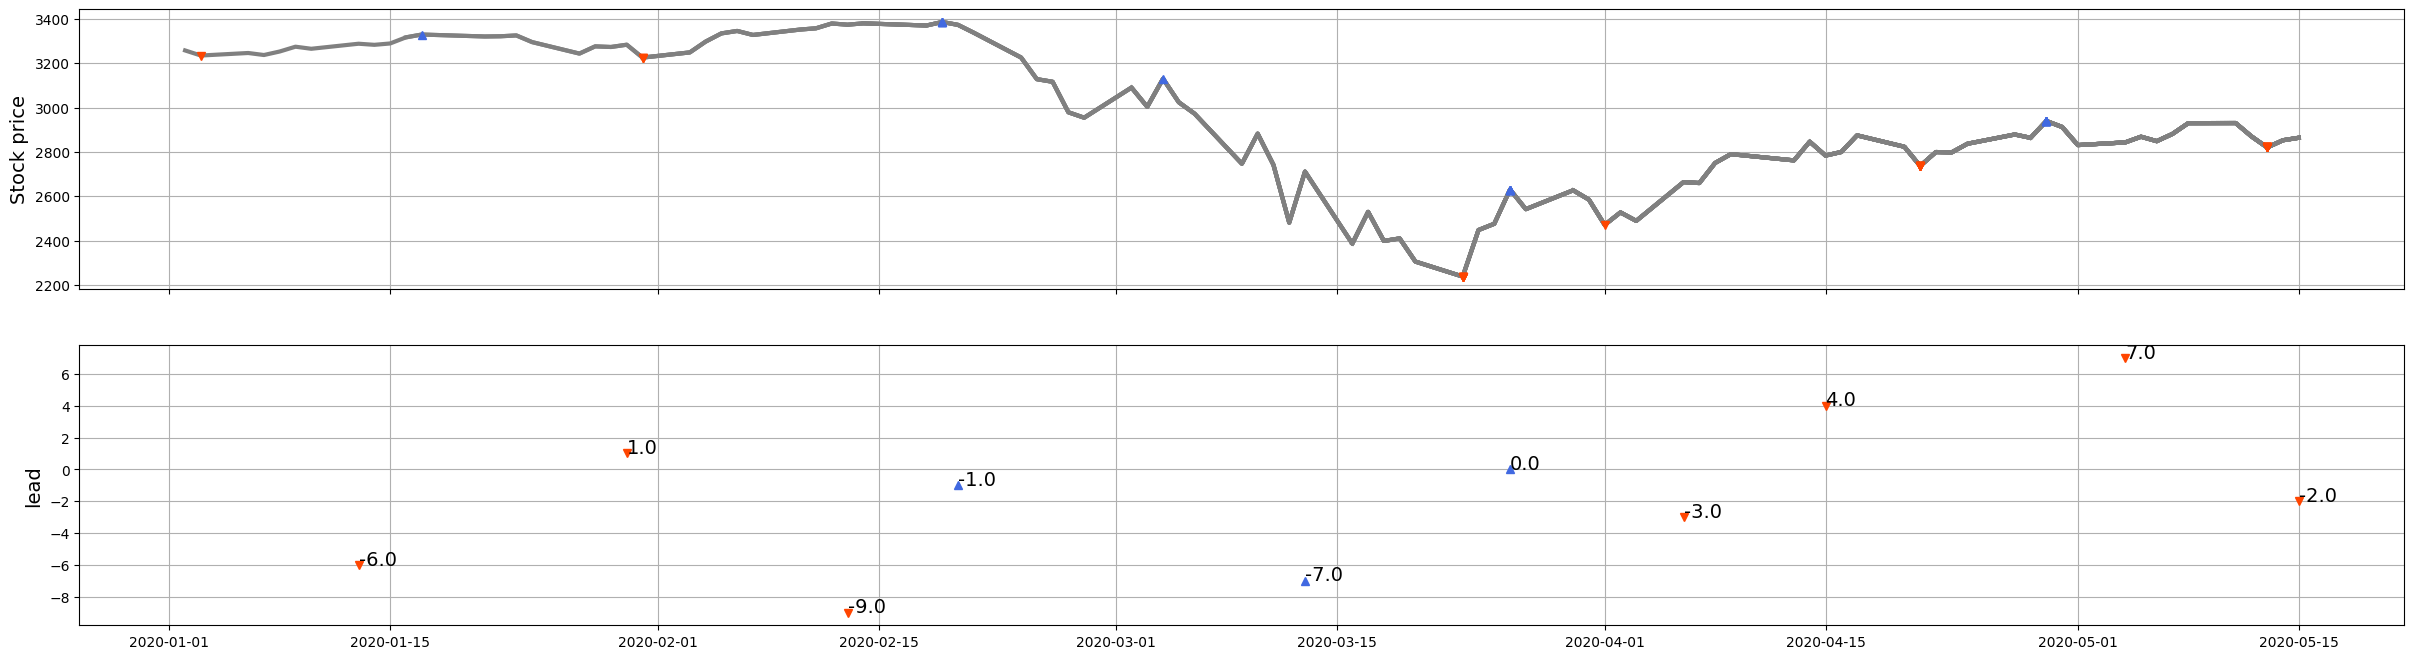

In [37]:
draw_plot_result_table(test_data, all_data, result_table, pv_range)

In [38]:
# for i in processed_signal:
#     fig, axes = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
#     axes[0].set_title(i, fontsize=40)
#     axes[0].plot(range(0, len(train_data[i])), train_data[i]['Close'])
#     axes[0].plot(range(0, len(train_data[i])), train_data[i]['peaks'], '^')
#     axes[0].plot(range(0, len(train_data[i])), train_data[i]['valleys'], 'v')
#     axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['Close'])
#     axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['peaks'], '^')
#     axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['valleys'], 'v')
#     axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['Close'])
#     axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['peaks'], '^')
#     axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['valleys'], 'v')
#     plt.xlim(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]]))
#     axes[0].grid()
#     axes[1].grid()
#     plt.xticks(np.arange(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]]), step=10))
#     plt.show()

In [39]:
def kbar(open, close, high, low, pos, ax):
    if close > open:             # 上漲
        color='green'                 # 紅 K 棒
        height=close - open   # 高度=收盤-開盤
        bottom=open             # 底部=開盤
    else:                               # 下跌
        color='red'              # 綠 k 棒
        height=open - close   # 高度=開盤-收盤
        bottom=close             # 底部=收盤
    # 繪製 k 棒實體      
    ax.bar(pos, height=height,bottom=bottom, width=1, color=color)
    # 繪製 k 棒上下影線
    ax.vlines(pos, high, low, color=color)

In [40]:
def draw_profit_plot(profit_table, pv_range):
    date_list = sorted(
        list(profit_table['in_date']) + list(profit_table['out_date']))
    plot_data = all_data.loc[date_list[0]:date_list[-1]]
    find_data_pv_function(plot_data, pv_range)
    fig, ax = plt.subplots(figsize=(20, 8))
    # plt.subplots(figsize=(20, 8))
    for i in plot_data.index:
        kbar(plot_data['Open'].loc[i], plot_data['Close'].loc[i], plot_data['High'].loc[i], plot_data['Low'].loc[i], i, ax)
    # ax.plot(plot_data['peaks'], '^', label='peaks', c='royalblue')
    # ax.plot(plot_data['valleys'], 'v', label='valleys', c='orangered')
    for i in profit_table.index:
        if profit_table.loc[i, 'pv'] == 'peak':
            arrow = patches.FancyArrowPatch((profit_table.loc[i, 'in_date'], profit_table.loc[i, 'in_price']), (profit_table.loc[i, 'out_date'], profit_table.loc[i, 'out_price']), 
                                            linestyle='--', mutation_scale=20, arrowstyle='->', edgecolor='red')
            ax.add_patch(arrow)
            ax.plot(profit_table.loc[i, 'in_date'], plot_data['High'].loc[profit_table.loc[i, 'in_date']]+10, 'v', color='red')
            ax.plot(profit_table.loc[i, 'out_date'], plot_data['Low'].loc[profit_table.loc[i, 'out_date']]-10, '^', color='green')

        elif profit_table.loc[i, 'pv'] == 'valley':
            arrow = patches.FancyArrowPatch((profit_table.loc[i, 'in_date'], profit_table.loc[i, 'in_price']), (profit_table.loc[i, 'out_date'], profit_table.loc[i, 'out_price']), 
                                linestyle='--', mutation_scale=20, arrowstyle='->', edgecolor='green')
            ax.add_patch(arrow)
            ax.plot(profit_table.loc[i, 'in_date'], plot_data['Low'].loc[profit_table.loc[i, 'in_date']]-10, '^', color='green')
            ax.plot(profit_table.loc[i, 'out_date'], plot_data['High'].loc[profit_table.loc[i, 'out_date']]+10, 'v', color='red')
            
        if 'strategy' in profit_table.columns:
            if profit_table.loc[i, 'strategy'] == 'stop_profit':
                ax.hlines(profit_table.loc[i, 'strategy_price'], profit_table.loc[i, 'in_date'], profit_table.loc[i, 'out_date'], color='green', linestyles='dotted')
            elif profit_table.loc[i, 'strategy'] == 'stop_loss':
                ax.hlines(profit_table.loc[i, 'strategy_price'], profit_table.loc[i, 'in_date'], profit_table.loc[i, 'out_date'], color='red', linestyles='dotted')
            
    # ax.annotate(f'{i}', (profit_table.loc[i, 'in_date'], profit_table.loc[i, 'in_price']-100), fontsize=14, c='black')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.grid()
    # plt.legend()
    plt.show()

In [41]:
def build_profit_table_method_1(result_table):
    profit_table = pd.DataFrame(columns=['in_date', 'in_price', 'out_date', 'out_price', 'pv', 'profit'])
    total_profit = 0
    for i in result_table.index:
        in_price = all_data['Open'].iloc[all_data.index.get_loc(result_table.loc[i, 't_date'])]
        out_price = all_data['Close'].iloc[all_data.index.get_loc(result_table.loc[i, 't_date'])+pv_range]
        if result_table.loc[i, 'pv'] == 'valley':
            profit = out_price - in_price
            profit_table.loc[i, 'pv'] = 'valley'
        else:
            profit = in_price - out_price
            profit_table.loc[i, 'pv'] = 'peak'
        profit_table.loc[i, 'in_date'] = result_table.loc[i, 't_date']
        profit_table.loc[i, 'in_price'] = in_price
        profit_table.loc[i, 'out_date'] = all_data.iloc[all_data.index.get_loc(result_table.loc[i, 't_date'])+pv_range].name
        profit_table.loc[i, 'out_price'] = out_price
        profit_table.loc[i, 'profit'] = profit
        total_profit += profit
    return total_profit, profit_table

In [42]:
def build_profit_table_method_2(result_table, profit_percentage, loss_percentage):
    '''percentage:fioat
    '''
    profit_table = pd.DataFrame(columns=['in_date', 'in_price', 'out_date', 'out_price', 'pv', 'profit', 'strategy', 'strategy_price'])
    total_profit = 0
    for i in result_table.index:
        in_price = all_data['Open'].iloc[all_data.index.get_loc(result_table.loc[i, 't_date'])]
        if result_table.loc[i, 'pv'] == 'valley':
            stop_profit_price = in_price*(1+profit_percentage)
            stop_loss_price = in_price*(1-loss_percentage)
        else:
            stop_profit_price = in_price*(1-profit_percentage)
            stop_loss_price = in_price*(1+loss_percentage)

        # print(in_price, stop_loss_price, stop_profit_price)
        start_index = all_data.index.get_loc(result_table.loc[i, 't_date'])
        end_index = all_data.index.get_loc(result_table.loc[i, 't_date'])+pv_range
        trade_data = all_data.iloc[start_index:end_index]
        # check out_price
        out_price = all_data['Close'].iloc[end_index]
        profit_table.loc[i, 'out_date'] = all_data.iloc[end_index].name
        for j in trade_data.index:
            high = trade_data['High'].loc[j]
            low = trade_data['Low'].loc[j]
            if result_table.loc[i, 'pv'] == 'valley':
                if high>=stop_profit_price:
                    out_price = stop_profit_price
                    profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                    profit_table.loc[i, 'strategy'] = 'stop_profit'
                    profit_table.loc[i, 'strategy_price'] = stop_profit_price
                    break
                elif low<=stop_loss_price:
                    out_price = stop_loss_price
                    profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                    profit_table.loc[i, 'strategy'] = 'stop_loss'
                    profit_table.loc[i, 'strategy_price'] = stop_loss_price
                    break
            elif result_table.loc[i, 'pv'] == 'peak':
                    if low<=stop_profit_price:
                        out_price = stop_profit_price
                        profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                        profit_table.loc[i, 'strategy'] = 'stop_profit'
                        profit_table.loc[i, 'strategy_price'] = stop_profit_price
                        break
                    elif high>=stop_loss_price:
                        out_price = stop_loss_price
                        profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                        profit_table.loc[i, 'strategy'] = 'stop_loss'
                        profit_table.loc[i, 'strategy_price'] = stop_loss_price
                        break

        if result_table.loc[i, 'pv'] == 'valley':
            profit = out_price - in_price
            profit_table.loc[i, 'pv'] = 'valley'
        else:
            profit = in_price - out_price
            profit_table.loc[i, 'pv'] = 'peak'
        profit_table.loc[i, 'in_date'] = result_table.loc[i, 't_date']
        profit_table.loc[i, 'in_price'] = in_price
        
        profit_table.loc[i, 'out_price'] = out_price
        profit_table.loc[i, 'profit'] = profit
        total_profit += profit
    return total_profit, profit_table

In [43]:
def build_profit_table_method_3(result_table, profit_percentage, loss_percentage):
    '''percentage:fioat
    '''
    profit_table = pd.DataFrame(columns=['in_date', 'in_price', 'out_date', 'out_price', 'pv', 'profit', 'strategy', 'strategy_price'])
    total_profit = 0
    for i in result_table.index:
        in_price = all_data['Open'].iloc[all_data.index.get_loc(result_table.loc[i, 't_date'])]
        # print(in_price, stop_loss_price, stop_profit_price)
        start_index = all_data.index.get_loc(result_table.loc[i, 't_date'])
        end_index = all_data.index.get_loc(result_table.loc[i, 't_date'])+pv_range
        trade_data = all_data.iloc[start_index:end_index]
        # check out_price
        out_price = all_data['Close'].iloc[end_index]
        profit_table.loc[i, 'out_date'] = all_data.iloc[end_index].name
        yesterday_close = all_data['Close'].iloc[all_data.index.get_loc(result_table.loc[i, 't_date'])-1]
        for j in trade_data.index:
            if result_table.loc[i, 'pv'] == 'valley':
                stop_profit_price = yesterday_close*(1+profit_percentage)
                stop_loss_price = yesterday_close*(1-loss_percentage)
            else:
                stop_profit_price = yesterday_close*(1-profit_percentage)
                stop_loss_price = yesterday_close*(1+loss_percentage)
            yesterday_close = trade_data['Close'].loc[j]
            high = trade_data['High'].loc[j]
            low = trade_data['Low'].loc[j]
            if result_table.loc[i, 'pv'] == 'valley':
                if high>=stop_profit_price:
                    out_price = stop_profit_price
                    profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                    profit_table.loc[i, 'strategy'] = 'stop_profit'
                    profit_table.loc[i, 'strategy_price'] = stop_profit_price
                    break
                elif low<=stop_loss_price:
                    out_price = stop_loss_price
                    profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                    profit_table.loc[i, 'strategy'] = 'stop_loss'
                    profit_table.loc[i, 'strategy_price'] = stop_loss_price
                    break
            elif result_table.loc[i, 'pv'] == 'peak':
                    if low<=stop_profit_price:
                        out_price = stop_profit_price
                        profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                        profit_table.loc[i, 'strategy'] = 'stop_profit'
                        profit_table.loc[i, 'strategy_price'] = stop_profit_price
                        break
                    elif high>=stop_loss_price:
                        out_price = stop_loss_price
                        profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                        profit_table.loc[i, 'strategy'] = 'stop_loss'
                        profit_table.loc[i, 'strategy_price'] = stop_loss_price
                        break

        if result_table.loc[i, 'pv'] == 'valley':
            profit = out_price - in_price
            profit_table.loc[i, 'pv'] = 'valley'
        else:
            profit = in_price - out_price
            profit_table.loc[i, 'pv'] = 'peak'
        profit_table.loc[i, 'in_date'] = result_table.loc[i, 't_date']
        profit_table.loc[i, 'in_price'] = in_price
        
        profit_table.loc[i, 'out_price'] = out_price
        profit_table.loc[i, 'profit'] = profit
        total_profit += profit
    return total_profit, profit_table

In [44]:
print('final_error = ', final_error)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(result_table)

final_error =  4.0
              s_date      t_date lead    ans_date      pv  error best_fit
window_0  2020-01-02  2020-01-13 -6.0  2020-01-03  valley  10.55        0
window_1  2020-01-16  2020-01-30  1.0  2020-01-31  valley  11.42        0
window_2  2020-01-31  2020-02-13 -9.0  2020-01-31  valley  10.14        0
window_3  2020-02-14  2020-02-20 -1.0  2020-02-19    peak   9.95        0
window_4  2020-03-02  2020-03-13 -7.0  2020-03-04    peak  10.44        0
window_5  2020-03-16  2020-03-26  0.0  2020-03-26    peak  11.08        0
window_6  2020-03-30  2020-04-06 -3.0  2020-04-01  valley   10.6        0
window_7  2020-04-14  2020-04-15  4.0  2020-04-21  valley  10.72        0
window_8  2020-04-28  2020-05-04  7.0  2020-05-13  valley  11.82        0
window_9  2020-05-12  2020-05-15 -2.0  2020-05-13  valley  10.07        0


In [45]:
total_profit, profit_table = build_profit_table_method_1(result_table)
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(profit_table)

total_profit = 636.390380859375
             in_date in_price    out_date out_price      pv  profit
window_0  2020-01-13  3271.13  2020-01-23   3325.54  valley   54.41
window_1  2020-01-30  3256.45  2020-02-10   3352.09  valley   95.64
window_2  2020-02-13   3365.9  2020-02-25   3128.21  valley -237.69
window_3  2020-02-20  3380.45  2020-03-02   3090.23    peak  290.22
window_4  2020-03-13  2569.99  2020-03-24   2447.33    peak  122.66
window_5  2020-03-26  2501.29  2020-04-06   2663.68    peak -162.39
window_6  2020-04-06  2578.28  2020-04-16   2799.55  valley  221.27
window_7  2020-04-15  2795.64  2020-04-24   2836.74  valley    41.1
window_8  2020-05-04  2815.01  2020-05-13    2820.0  valley    4.99
window_9  2020-05-15  2829.95  2020-05-27   3036.13  valley  206.18


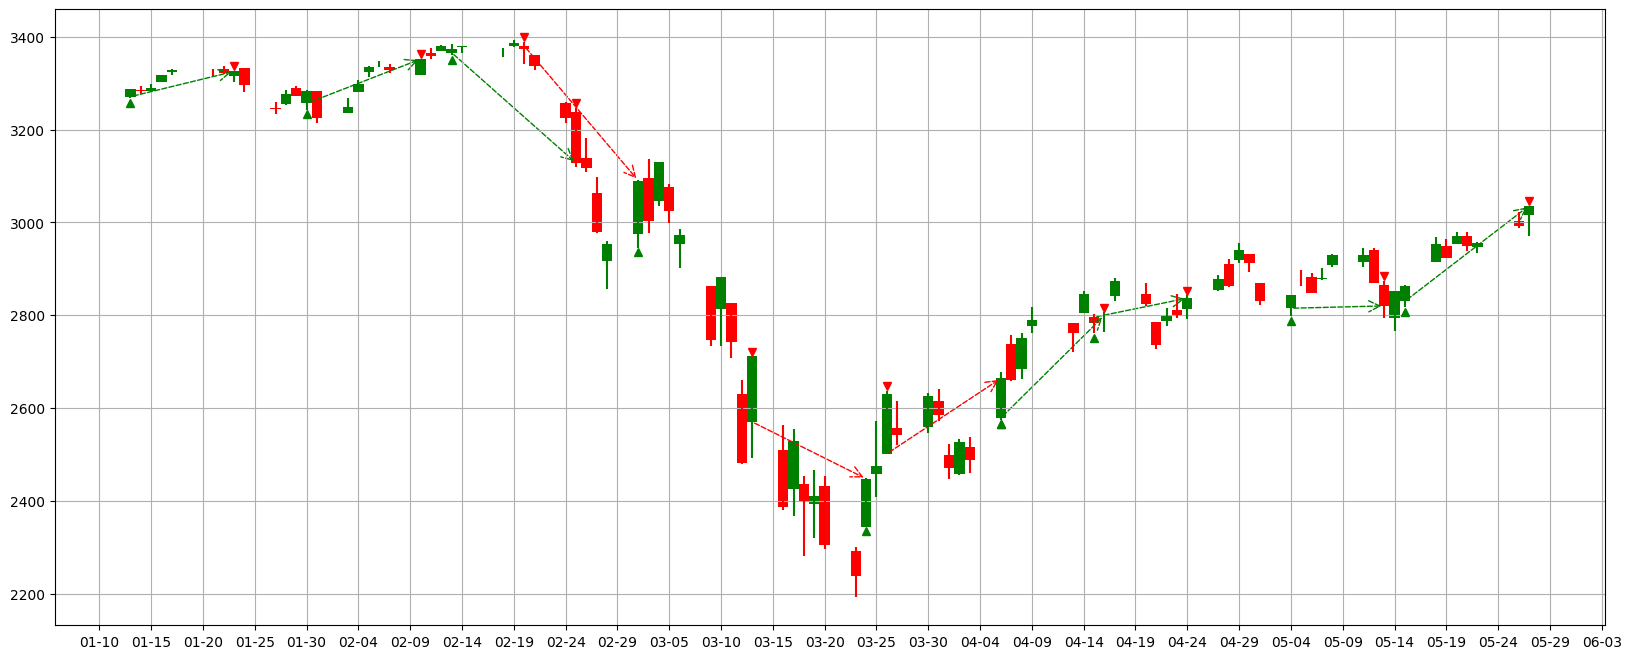

In [46]:
draw_profit_plot(profit_table, pv_range)

In [47]:
total_profit, profit_table = build_profit_table_method_2(result_table, profit_percentage, loss_percentage)
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(profit_table)

total_profit = 855.1124755859378
             in_date in_price    out_date out_price      pv   profit  \
window_0  2020-01-13  3271.13  2020-01-23   3325.54  valley    54.41   
window_1  2020-01-30  3256.45  2020-02-10   3352.09  valley    95.64   
window_2  2020-02-13   3365.9  2020-02-25   3128.21  valley  -237.69   
window_3  2020-02-20  3380.45  2020-02-27  3042.405    peak  338.045   
window_4  2020-03-13  2569.99  2020-03-18  2312.991    peak  256.999   
window_5  2020-03-26  2501.29  2020-04-06   2663.68    peak  -162.39   
window_6  2020-04-06  2578.28  2020-04-14  2836.108  valley  257.828   
window_7  2020-04-15  2795.64  2020-04-24   2836.74  valley     41.1   
window_8  2020-05-04  2815.01  2020-05-13    2820.0  valley     4.99   
window_9  2020-05-15  2829.95  2020-05-27   3036.13  valley   206.18   

             strategy strategy_price  
window_0          NaN            NaN  
window_1          NaN            NaN  
window_2          NaN            NaN  
window_3  stop_pro

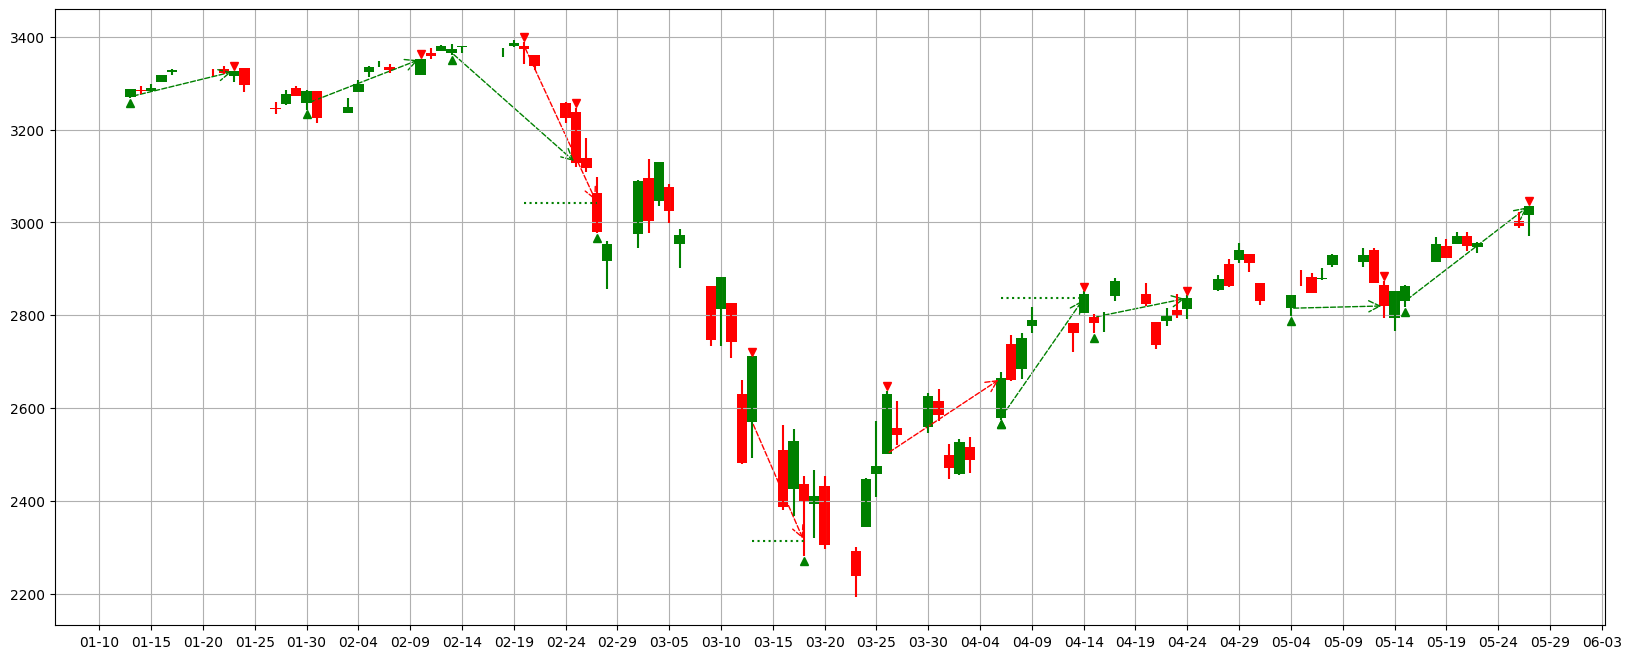

In [48]:
draw_profit_plot(profit_table, pv_range)

In [49]:
total_profit, profit_table = build_profit_table_method_3(result_table, profit_percentage, loss_percentage)
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(profit_table)

total_profit = 643.8024414062497
             in_date in_price    out_date out_price      pv   profit  \
window_0  2020-01-13  3271.13  2020-01-23   3325.54  valley    54.41   
window_1  2020-01-30  3256.45  2020-02-10   3352.09  valley    95.64   
window_2  2020-02-13   3365.9  2020-02-25   3128.21  valley  -237.69   
window_3  2020-02-20  3380.45  2020-03-02   3090.23    peak   290.22   
window_4  2020-03-13  2569.99  2020-03-16  2439.918    peak  130.072   
window_5  2020-03-26  2501.29  2020-04-06   2663.68    peak  -162.39   
window_6  2020-04-06  2578.28  2020-04-16   2799.55  valley   221.27   
window_7  2020-04-15  2795.64  2020-04-24   2836.74  valley     41.1   
window_8  2020-05-04  2815.01  2020-05-13    2820.0  valley     4.99   
window_9  2020-05-15  2829.95  2020-05-27   3036.13  valley   206.18   

             strategy strategy_price  
window_0          NaN            NaN  
window_1          NaN            NaN  
window_2          NaN            NaN  
window_3          

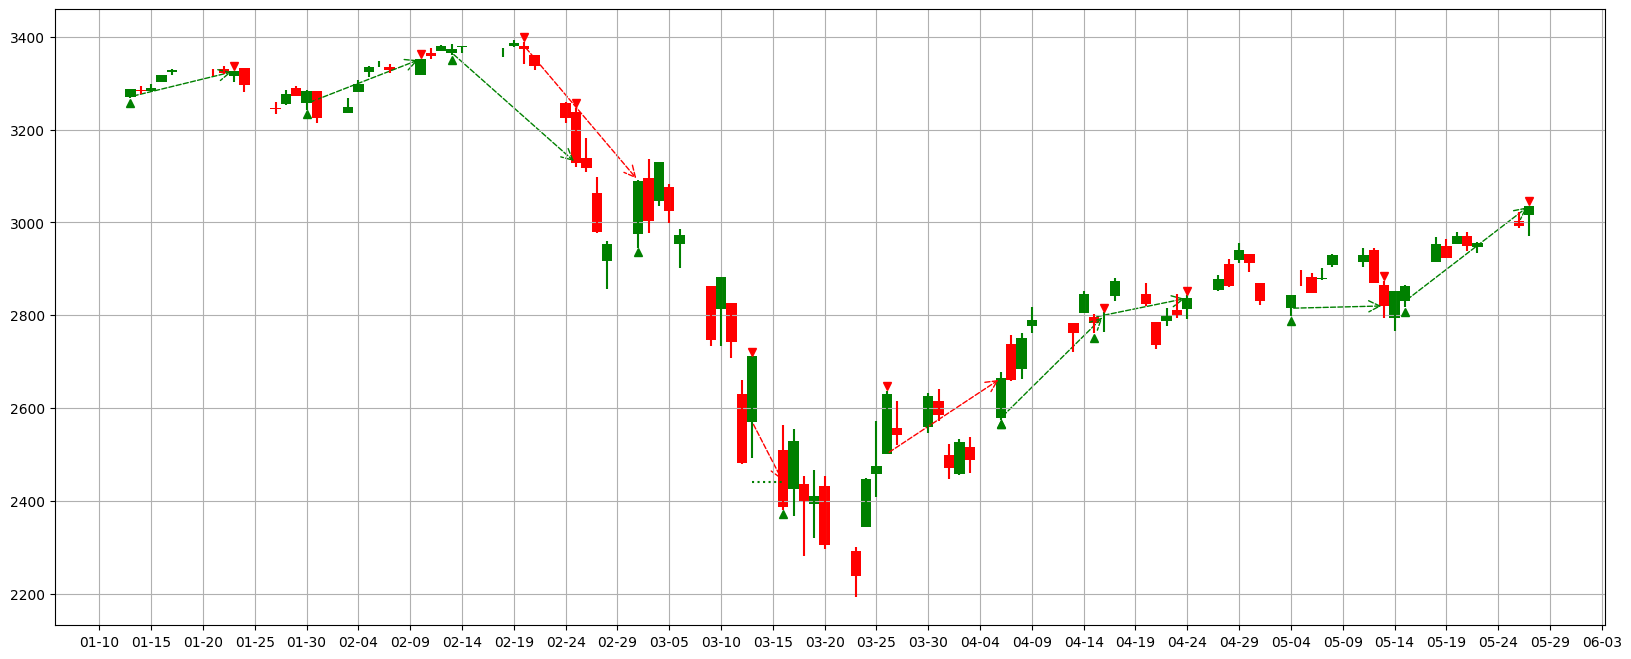

In [50]:
draw_profit_plot(profit_table, pv_range)